In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

from architectures.basic import BoundingBoxModel
from functions.datasets import get_loaders
from functions.loop_management import EarlyStopping
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
dataset, train_loader, valid_loader = get_loaders(
    os.path.join("data", "train_images"),
    os.path.join("data", "train_coco_annotations.json")
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.13s)
creating index...
index created!
cuda


In [4]:
model = BoundingBoxModel().to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [5]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")
    
    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()
            
            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    
    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss,
        model,
        path=os.path.join("checkpoints", "checkpoint_2_bigger_basic.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 227/227 [00:16<00:00, 13.49it/s, Train Loss=19.6]


Epoch 1, Loss: 19.59461191572282


Epoch 1/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.92it/s, Val Loss=12.3]


Validation Loss: 12.261310106857232
Validation loss decreased (inf --> 12.261310).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 17.38it/s, Train Loss=9.89]


Epoch 2, Loss: 9.893578018911084


Epoch 2/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 16.59it/s, Val Loss=9.37]


Validation Loss: 9.372584760976784
Validation loss decreased (12.261310 --> 9.372585).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 17.05it/s, Train Loss=8.67]


Epoch 3, Loss: 8.674869896556837


Epoch 3/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 16.97it/s, Val Loss=8.31]


Validation Loss: 8.309579756816579
Validation loss decreased (9.372585 --> 8.309580).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.57it/s, Train Loss=8.4] 


Epoch 4, Loss: 8.395476677344234


Epoch 4/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.46it/s, Val Loss=8.57]


Validation Loss: 8.568209080969185
EarlyStopping counter: 1 out of 7


Epoch 5/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.88it/s, Train Loss=7.91]


Epoch 5, Loss: 7.907204098638459


Epoch 5/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.77it/s, Val Loss=7.74]


Validation Loss: 7.743000505254132
Validation loss decreased (8.309580 --> 7.743001).  Saving model ...


Epoch 6/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 17.26it/s, Train Loss=7.81]


Epoch 6, Loss: 7.807332519917761


Epoch 6/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.38it/s, Val Loss=7.35]


Validation Loss: 7.347935514828182
Validation loss decreased (7.743001 --> 7.347936).  Saving model ...


Epoch 7/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.92it/s, Train Loss=7.51]


Epoch 7, Loss: 7.511223179653353


Epoch 7/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.52it/s, Val Loss=7.2] 


Validation Loss: 7.197723090386075
Validation loss decreased (7.347936 --> 7.197723).  Saving model ...


Epoch 8/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.06it/s, Train Loss=7.31]


Epoch 8, Loss: 7.309240872639392


Epoch 8/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.21it/s, Val Loss=7.25]


Validation Loss: 7.246949683201995
EarlyStopping counter: 1 out of 7


Epoch 9/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.74it/s, Train Loss=7.29]


Epoch 9, Loss: 7.294996587190334


Epoch 9/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.62it/s, Val Loss=8.28]


Validation Loss: 8.281839847564697
EarlyStopping counter: 2 out of 7


Epoch 10/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.07it/s, Train Loss=6.96]


Epoch 10, Loss: 6.9581672231531355


Epoch 10/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.77it/s, Val Loss=7.82]


Validation Loss: 7.817894675132987
EarlyStopping counter: 3 out of 7


Epoch 11/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.95it/s, Train Loss=6.9] 


Epoch 11, Loss: 6.900227870184945


Epoch 11/25 - Validation: 100%|██████████| 227/227 [00:14<00:00, 15.21it/s, Val Loss=7]   


Validation Loss: 6.997369640199098
Validation loss decreased (7.197723 --> 6.997370).  Saving model ...


Epoch 12/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 17.08it/s, Train Loss=6.71]


Epoch 12, Loss: 6.7136797106738655


Epoch 12/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.45it/s, Val Loss=6.74]


Validation Loss: 6.743242389830199
Validation loss decreased (6.997370 --> 6.743242).  Saving model ...


Epoch 13/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.78it/s, Train Loss=6.61]


Epoch 13, Loss: 6.606552315178422


Epoch 13/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.20it/s, Val Loss=6.37]


Validation Loss: 6.372065294156515
Validation loss decreased (6.743242 --> 6.372065).  Saving model ...


Epoch 14/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.08it/s, Train Loss=6.51]


Epoch 14, Loss: 6.511547968776216


Epoch 14/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.06it/s, Val Loss=8.48]


Validation Loss: 8.478036321732441
EarlyStopping counter: 1 out of 7


Epoch 15/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.07it/s, Train Loss=6.45]


Epoch 15, Loss: 6.45012540439152


Epoch 15/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.21it/s, Val Loss=6.79]


Validation Loss: 6.786614701611355
EarlyStopping counter: 2 out of 7


Epoch 16/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.22it/s, Train Loss=6.2] 


Epoch 16, Loss: 6.202672674792454


Epoch 16/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.38it/s, Val Loss=6.31]


Validation Loss: 6.307219259539365
Validation loss decreased (6.372065 --> 6.307219).  Saving model ...


Epoch 17/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.00it/s, Train Loss=6.34]


Epoch 17, Loss: 6.335831196822784


Epoch 17/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 17.56it/s, Val Loss=6.56]


Validation Loss: 6.556076822827041
EarlyStopping counter: 1 out of 7


Epoch 18/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.13it/s, Train Loss=6.13]


Epoch 18, Loss: 6.13266996665148


Epoch 18/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.19it/s, Val Loss=6.04]


Validation Loss: 6.039986921302022
Validation loss decreased (6.307219 --> 6.039987).  Saving model ...


Epoch 19/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.91it/s, Train Loss=6.02]


Epoch 19, Loss: 6.016107155888091


Epoch 19/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.01it/s, Val Loss=6.36]


Validation Loss: 6.358265874669415
EarlyStopping counter: 1 out of 7


Epoch 20/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.04it/s, Train Loss=6.01]


Epoch 20, Loss: 6.005596798422053


Epoch 20/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.26it/s, Val Loss=9.7] 


Validation Loss: 9.704361331620406
EarlyStopping counter: 2 out of 7


Epoch 21/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 18.11it/s, Train Loss=6.09]


Epoch 21, Loss: 6.090566354701172


Epoch 21/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 16.77it/s, Val Loss=5.54]


Validation Loss: 5.542149024912964
Validation loss decreased (6.039987 --> 5.542149).  Saving model ...


Epoch 22/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.87it/s, Train Loss=5.92]


Epoch 22, Loss: 5.921263295648382


Epoch 22/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.04it/s, Val Loss=5.69]


Validation Loss: 5.691074717937587
EarlyStopping counter: 1 out of 7


Epoch 23/25 - Training: 100%|██████████| 227/227 [00:13<00:00, 16.73it/s, Train Loss=5.84]


Epoch 23, Loss: 5.843908806729422


Epoch 23/25 - Validation: 100%|██████████| 227/227 [00:13<00:00, 17.08it/s, Val Loss=6.1] 


Validation Loss: 6.102805020000441
EarlyStopping counter: 2 out of 7


Epoch 24/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.94it/s, Train Loss=5.77]


Epoch 24, Loss: 5.773513842259209


Epoch 24/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.01it/s, Val Loss=5.93]


Validation Loss: 5.928793279084865
EarlyStopping counter: 3 out of 7


Epoch 25/25 - Training: 100%|██████████| 227/227 [00:12<00:00, 17.99it/s, Train Loss=5.82]


Epoch 25, Loss: 5.824863784638795


Epoch 25/25 - Validation: 100%|██████████| 227/227 [00:12<00:00, 18.12it/s, Val Loss=5.21]

Validation Loss: 5.2130591470239445
Validation loss decreased (5.542149 --> 5.213059).  Saving model ...
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

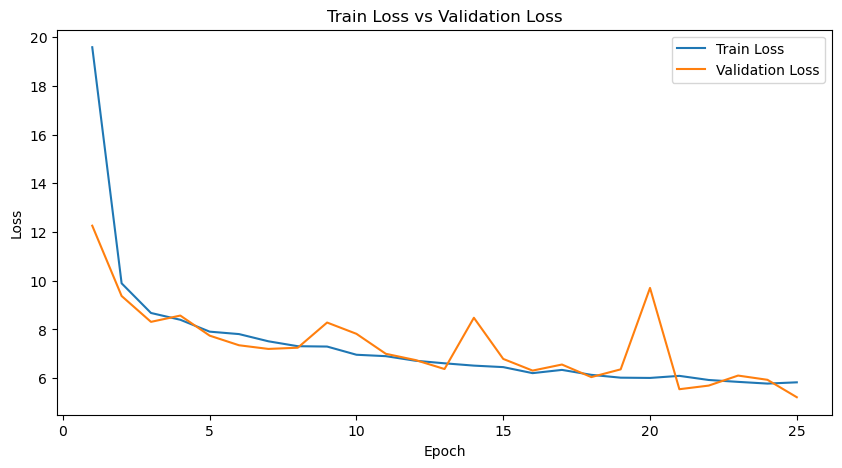

In [6]:
plot_losses(num_epochs, train_losses, val_losses)

In [7]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': -early_stopping.best_score,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_1_basic.pt"))